# Qdrant

- Author: [HyeonJong Moon](https://github.com/hj0302)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

## Overview

This tutorial is a guide to `the Qdrant Vector Store` .

`Qdrant` is a powerful vector similarity search engine, offering an API designed for the efficient storage, searching, and management of vectors, augmented by additional payloads. These payloads serve as extra data that enhance the precision of searches and offer valuable insights. By managing vector data, Qdrant facilitates both similarity and semantic searches, effectively identifying vectors that are nearest to a specified query vector. The engine supports various distance metrics, including `Euclidean distance` , `cosine similarity` , and `dot product` , enabling versatile applications across different domains.


### Table of Contents

- [Overview](#overview)
- [Initialization](#initialization)
- [Manage-VecotorStore](#manage-vectorstore)
- [Query-VectorStor](#query-vectorstore)
- [Multimodal-Search](#multimodal-search)

### References

- [LangChain Qdrant Reference](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Qdrant Official Reference](https://qdrant.tech/documentation/frameworks/langchain/)
- [Qdrant Install Reference](https://qdrant.tech/documentation/guides/installation/)
- [Qdrant Cloud Reference](https://cloud.qdrant.io)

----

You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [1]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain_openai",
        "langchain_qdrant",
        "fastembed",
        "qdrant_client"
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPEN_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Qdrant",
    }
)

Environment variables have been set successfully.


### Create API Key

Please create an API KEY from link.
Set the user's Google API key as the environment variable GOOGLE_API_KEY.
You can alternatively set GOOGLE_API_KEY in .env file and load it.

[Note] This is not necessary if you've already set GOOGLE_API_KEY in previous steps.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Setup

Here are the main ways to use the Qdrant vector store:

- Local mode, no server required
    - In-memory
    - On-disk storage
- Docker deployments
- Qdrant Cloud

See the [installation instructions](https://qdrant.tech/documentation/guides/installation/).

## Initialization

### In-memory

In memory, for simple tests or quick experiments, you might want to store data only in memory. This way, the data is automatically deleted when the client is terminated, typically at the end of your script or notebook.

In [5]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai import OpenAIEmbeddings

# Step 1: Initialize Qdrant client
client = QdrantClient(":memory:")

# Step 2: Create a Qdrant collection
client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=3072, distance=Distance.COSINE),
)

# Step 3: Initialize QdrantVectorStore
vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=OpenAIEmbeddings(model="text-embedding-3-large"),
)

### On-disk storage

In On-disk storage, you can store vectors on disk without using the Qdrant server. This ensures that your data persists even when you run the program again.

In [6]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai import OpenAIEmbeddings

# Step 1: Initialize Qdrant client
client = QdrantClient(path="./langchain_qdrant")

# Step 2: Create a Qdrant collection
client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=3072, distance=Distance.COSINE),
)

# Step 3: Initialize QdrantVectorStore
vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=OpenAIEmbeddings(model="text-embedding-3-large"),
)

### docker-deployments

You can also run Qdrant in a production environment using [Docker](https://qdrant.tech/documentation/guides/installation/#docker) and [Docker Compose](https://qdrant.tech/documentation/guides/installation/#docker-compose). To do this, follow the setup instructions in the Docker and Docker Compose development sections.

In [7]:
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings

url = "http://localhost:6333"  # URL of the Qdrant server
docs = []  # List of documents to store in Qdrant (add your documents here)

# Initializing QdrantVectorStore
vector_store = QdrantVectorStore.from_documents(
    docs,
    embedding=OpenAIEmbeddings(model="text-embedding-3-large"),
    url=url,
    prefer_grpc=False,
    collection_name="demo_collection",
)

### Qdrant Cloud

You can set up a production environment using [Qdrant Cloud](https://cloud.qdrant.io/), which offers fully managed Qdrant databases. This service provides horizontal and vertical scaling, one-click installation and upgrades, as well as monitoring, logging, backup, and disaster recovery features. For more information, please refer to the [Qdrant Cloud documentation](https://qdrant.tech/documentation/cloud/).

In [8]:
import os
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings

docs = []

# Fetch the Qdrant server URL and API key from environment variables.
url = os.environ["QDRANT_ENDPOINT"]
api_key = os.environ["QDRANT_API_KEY"]

# Initializing QdrantVectorStore
vector_store = QdrantVectorStore.from_documents(
    docs,
    embedding=OpenAIEmbeddings(model="text-embedding-3-large"),
    url=url,
    prefer_grpc=False,
    api_key=api_key,
    collection_name="demo_collection",
)

## Using an existing collection

To get an instance of `langchain_qdrant.QdrantVectorStore` without loading any new documents or texts, you can use the `QdrantVectorStore.from_existing_collection()` method.

In [9]:
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings

# Importing and initializing QdrantVectorStore from an existing collection
vector_store = QdrantVectorStore.from_existing_collection(
    embedding=OpenAIEmbeddings(model="text-embedding-3-large"),
    collection_name="demo_collection",
    url="http://localhost:6333",
)

## Manage VectorStore

Once you have created your vector store, we can interact with it by adding and deleting different items.

### Add items to vector store

We can add items to our vector store by using the `add_documents` function.
You can add items to your vector store using Qdrant's `add_documents` function. If the ID of the document you're adding matches an existing ID, the document will be upserted, meaning the existing data will be overwritten with the new data.

In [10]:
from uuid import uuid4
from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)

documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]

uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['5283dcc8-b895-4434-9596-426c045ed67c',
 '039427b5-a19e-4926-afc1-13cfd54f09c4',
 '91bd3fd4-11df-47b4-a795-37f729e04692',
 'dc0ffa38-4906-4932-91ef-a81866a20e3c',
 '85f83545-8215-4c1d-a47b-11219c36c810',
 'b857addb-fc90-4397-8ede-dd9746a5281e',
 'ce0e6f84-6247-4a98-bcb7-607ef498730c',
 '4896cf73-357e-423d-b38a-9faf9a425424',
 '3ea599f1-1ce1-4d6a-a8bf-963d099b968a',
 '15fa4af1-a40f-4289-be8b-0246ff7638c6']

### Delete items from vector store

To remove items from your vector store, you can use the `delete` function. This function allows you to specify the criteria for deletion, such as IDs or filters.

In [11]:
vector_store.delete(ids=[uuids[-1]])

True

## Query VectorStore

Once your vector store has been created and the relevant documents have been added you will most likely wish to query it during the running of your chain or agent.

### Query directly

The simplest scenario for using `Qdrant vector store` is to perform a similarity search. Under the hood, our query will be encoded into vector embeddings and used to find similar documents in Qdrant collection.

In [12]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model="text-embedding-3-large")

query = "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows"

# Create a QdrantVectorStore
vectore_store = QdrantVectorStore.from_documents(
    documents,
    embedding=embedding,
    location=":memory:",
    collection_name="demo_collection",
)

# Perform similarity search in the vector store
results = vector_store.similarity_search(
    query=query,
    k=3,
)

for res in results:
    print(f"* {res.page_content}\n [{res.metadata}]\n\n")

* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': 'eec2785f-935c-4461-b9d2-ec5e2ca84bee', '_collection_name': 'demo_collection'}]


* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': '4b5d6660-98a1-4acb-828c-cd585a1882e2', '_collection_name': 'demo_collection'}]


* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': '4896cf73-357e-423d-b38a-9faf9a425424', '_collection_name': 'demo_collection'}]




`QdrantVectorStore` supports 3 modes for similarity searches. They can be configured using the `retrieval_mode` parameter when setting up the class.

- Dense Vector Search(Default)
- Sparse Vector Search
- Hybrid Search

### Dense Vector Search
To search with only dense vectors,

- The `retrieval_mode` parameter should be set to `RetrievalMode.DENSE` (default).
- A [dense embeddings](https://python.langchain.com/docs/integrations/text_embedding/) value should be provided to the `embedding` parameter.

In [13]:
from langchain_qdrant import RetrievalMode
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model="text-embedding-3-large")

query = "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows"

# Create a QdrantVectorStore
vectore_store = QdrantVectorStore.from_documents(
    documents,
    embedding=embedding,
    location=":memory:",
    collection_name="demo_collection",
    retrieval_mode=RetrievalMode.DENSE,
)

# Perform similarity search in the vector store
results = vector_store.similarity_search(
    query=query,
    k=3,
)

for res in results:
    print(f"* {res.page_content}\n [{res.metadata}]\n\n")

* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': 'eec2785f-935c-4461-b9d2-ec5e2ca84bee', '_collection_name': 'demo_collection'}]


* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': '4b5d6660-98a1-4acb-828c-cd585a1882e2', '_collection_name': 'demo_collection'}]


* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': '4896cf73-357e-423d-b38a-9faf9a425424', '_collection_name': 'demo_collection'}]




### Sparse Vector Search

To search with only sparse vectors,

The `retrieval_mode` parameter should be set to `RetrievalMode.SPARSE` .
An implementation of the [SparseEmbeddings](https://github.com/langchain-ai/langchain/blob/master/libs/partners/qdrant/langchain_qdrant/sparse_embeddings.py) interface using any sparse embeddings provider has to be provided as value to the `sparse_embedding` parameter.
The `langchain-qdrant` package provides a FastEmbed based implementation out of the box.

To use it, install the [FastEmbed](https://github.com/qdrant/fastembed) package.

pip install fastembed

In [14]:
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain_openai import OpenAIEmbeddings


embedding = OpenAIEmbeddings(model="text-embedding-3-large")
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

query = "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows"

# Create a QdrantVectorStore
vectore_store = QdrantVectorStore.from_documents(
    documents,
    embedding=embedding,
    sparse_embedding=sparse_embeddings,
    location=":memory:",
    collection_name="demo_collection",
    retrieval_mode=RetrievalMode.SPARSE,
)

# Perform similarity search in the vector store
results = vector_store.similarity_search(
    query=query,
    k=3,
)

for res in results:
    print(f"* {res.page_content}\n [{res.metadata}]\n\n")

* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': 'eec2785f-935c-4461-b9d2-ec5e2ca84bee', '_collection_name': 'demo_collection'}]


* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': '4b5d6660-98a1-4acb-828c-cd585a1882e2', '_collection_name': 'demo_collection'}]


* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': '4896cf73-357e-423d-b38a-9faf9a425424', '_collection_name': 'demo_collection'}]




### Hybrid Vector Search
To perform a hybrid search using dense and sparse vectors with score fusion,

- The `retrieval_mode` parameter should be set to `RetrievalMode.HYBRID` .
- A [ `dense embeddings` ](https://python.langchain.com/docs/integrations/text_embedding/) value should be provided to the `embedding` parameter.
- An implementation of the [ `SparseEmbeddings` ](https://github.com/langchain-ai/langchain/blob/master/libs/partners/qdrant/langchain_qdrant/sparse_embeddings.py) interface using any sparse embeddings provider has to be provided as value to the `sparse_embedding` parameter.

Note that if you've added documents with the `HYBRID` mode, you can switch to any retrieval mode when searching. Since both the dense and sparse vectors are available in the collection.

In [15]:
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain_openai import OpenAIEmbeddings

query = "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows"

embedding = OpenAIEmbeddings(model="text-embedding-3-large")
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

# Create a QdrantVectorStore
vector_store = QdrantVectorStore.from_documents(
    documents,
    embedding=embedding,
    sparse_embedding=sparse_embeddings,
    location=":memory:",
    collection_name="demo_collection",
    retrieval_mode=RetrievalMode.HYBRID,
)

# Perform similarity search in the vector store
results = vector_store.similarity_search(
    query=query,
    k=3,
)

for res in results:
    print(f"* {res.page_content}\n [{res.metadata}]\n\n")

* LangGraph is the best framework for building stateful, agentic applications!
 [{'source': 'tweet', '_id': 'b98d59904f5243ffb3be5f1d23273917', '_collection_name': 'demo_collection'}]


* Building an exciting new project with LangChain - come check it out!
 [{'source': 'tweet', '_id': 'a6c86adcbddc4b538ab86a3cbb520cfe', '_collection_name': 'demo_collection'}]


* Wow! That was an amazing movie. I can't wait to see it again.
 [{'source': 'tweet', '_id': '75705e8613f74c16a039484b97e59603', '_collection_name': 'demo_collection'}]




If you want to execute a similarity search and receive the corresponding scores you can run:

In [16]:
query = "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows"

results = vector_store.similarity_search_with_score(
    query=query,
    k=3,
)
for doc, score in results:
    print(f"* [SIM={score:3f}] {doc.page_content}\n[{doc.metadata}]\n\n")

* [SIM=1.000000] LangGraph is the best framework for building stateful, agentic applications!
[{'source': 'tweet', '_id': 'b98d59904f5243ffb3be5f1d23273917', '_collection_name': 'demo_collection'}]


* [SIM=0.666667] Building an exciting new project with LangChain - come check it out!
[{'source': 'tweet', '_id': 'a6c86adcbddc4b538ab86a3cbb520cfe', '_collection_name': 'demo_collection'}]


* [SIM=0.250000] Wow! That was an amazing movie. I can't wait to see it again.
[{'source': 'tweet', '_id': '75705e8613f74c16a039484b97e59603', '_collection_name': 'demo_collection'}]




### Query by turning into retriever

You can also transform the vector store into a retriever for easier usage in your chains.



In [17]:
retriever = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 1},
)

retriever.invoke("What is Langchain?")

[Document(metadata={'source': 'tweet', '_id': 'a6c86adcbddc4b538ab86a3cbb520cfe', '_collection_name': 'demo_collection'}, page_content='Building an exciting new project with LangChain - come check it out!')]

## Multimodal Search

Different combinations of data modalities, such as text, images, video, and audio, form useful use cases for semantic search applications.

In this simple tutorial, we are working with two simple modalities: image and textual data. However, by choosing an appropriate embedding model to bridge the semantic gap, we can create semantic search applications with a combination of modalities.

In [18]:
# Sample dataset of documents containing captions and image paths
documents = [
    {"caption": "a dog", "image": "./images/qdrant_01.png"},
    {"caption": "a cat", "image": "./images/qdrant_02.png"},
    {"caption": "a lion", "image": "./images/qdrant_03.png"},
    {"caption": "a rabbit", "image": "./images/qdrant_04.png"},
    {"caption": "a tiger", "image": "./images/qdrant_05.png"},
    {"caption": "an elephant", "image": "./images/qdrant_06.png"},
]

In [19]:
from fastembed import TextEmbedding, ImageEmbedding

# Step 1: Initialize the CLIP text encoder
text_model_name = "Qdrant/clip-ViT-B-32-text"  # Model name for the CLIP text encoder
text_model = TextEmbedding(model_name=text_model_name)  # Load the text embedding model
text_embeddings_size = text_model._get_model_description(text_model_name)[
    "dim"
]  # Get embedding dimension (512)

# Step 2: Embed captions (text) in the dataset
# Extract captions from the documents and generate their embeddings
texts_embeded = list(text_model.embed([document["caption"] for document in documents]))

# Step 3: Initialize the CLIP image encoder
image_model_name = (
    "Qdrant/clip-ViT-B-32-vision"  # Model name for the CLIP image encoder
)
image_model = ImageEmbedding(
    model_name=image_model_name
)  # Load the image embedding model
image_embeddings_size = image_model._get_model_description(image_model_name)[
    "dim"
]  # Get embedding dimension (512)

# Step 4: Embed images in the dataset
# Extract image paths from the documents and generate their embeddings
images_embeded = list(image_model.embed([document["image"] for document in documents]))

In [20]:
from qdrant_client import QdrantClient, models

# Initialize Qdrant client with in-memory storage
client = QdrantClient(":memory:")

if not client.collection_exists("text_image"):
    client.create_collection(
        collection_name="text_image",
        vectors_config={
            # Define the vector configuration for "image" embeddings
            "image": models.VectorParams(
                size=image_embeddings_size,  # Size of the image embeddings (e.g., 512)
                distance=models.Distance.COSINE,  # Use cosine similarity for image embeddings
            ),
            # Define the vector configuration for "text" embeddings
            "text": models.VectorParams(
                size=text_embeddings_size,  # Size of the text embeddings (e.g., 512)
                distance=models.Distance.COSINE,  # Use cosine similarity for text embeddings
            ),
        },
    )

In [21]:
# uppload our images with text to the Collection.
client.upload_points(
    collection_name="text_image",
    points=[
        models.PointStruct(
            id=idx,
            vector={
                "text": texts_embeded[
                    idx
                ],  # Text embedding (generated from the caption)
                "image": images_embeded[
                    idx
                ],  # Image embedding (generated from the image)
            },
            payload=doc,
        )
        for idx, doc in enumerate(documents)
    ],
)

### Text-to-Image

This process demonstrates how to retrieve the most relevant image from a dataset stored in a Qdrant collection based on a given textual description

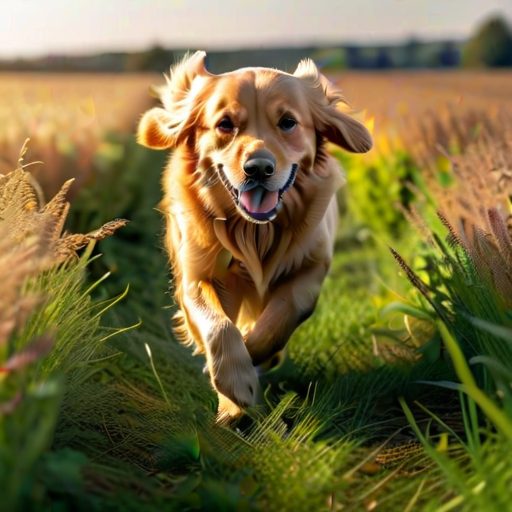

In [22]:
from PIL import Image

# Embed the query text
find_image = text_model.embed(["A running dog"])

# Perform a similarity search in the Qdrant collection
search_results = client.search(
    collection_name="text_image",  # The collection to search within
    query_vector=(
        "image",
        list(find_image)[0],
    ),  # Search among image vectors using the text query's embedding
    with_payload=[
        "image"
    ],  # Retrieve the image path from the payload for the search result
    limit=1,
)

# Open and display the retrieved image
Image.open(search_results[0].payload["image"])

### Image-to-Text

This process demonstrates how to retrieve the most relevant textual description (caption) from a dataset stored in a Qdrant collection based on a given image

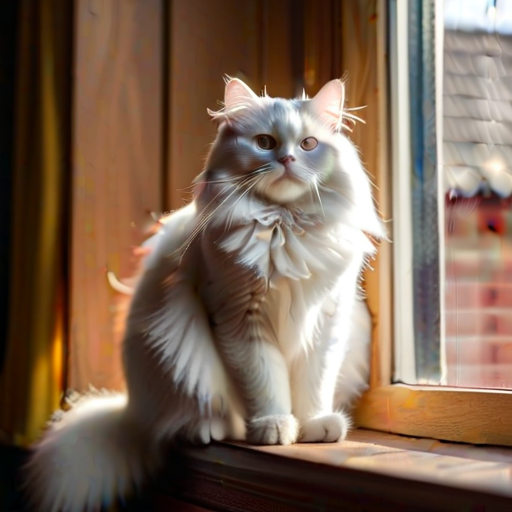

'a cat'

In [23]:
from IPython.display import display

# Embed the query image
find_image = image_model.embed(["./images/qdrant_02.png"])
display(Image.open("./images/qdrant_02.png"))

# Perform a similarity search in the Qdrant collection
search_results = client.search(
    collection_name="text_image",  # The collection to search within
    query_vector=(
        "text",
        list(find_image)[0],
    ),  # Search among text vectors using the image query's embedding
    with_payload=[
        "caption"
    ],  # Retrieve the caption field from the payload for the search results
    limit=1,
)

# Retrieve the caption
result_caption = search_results[0].payload["caption"]
result_caption